In [199]:
import sys

sys.path.append('../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [200]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios                     (chi)

init = [1]

loc1_varying_factor = pandas.DataFrame(
    data={'com1_pur': [1.0, 0.6, 0.25, 0.13, 0.17, 0.57, 0.72, 0.49, 0.21, 0.3, 0.59, 0.69]})

loc6_varying_factor = pandas.DataFrame(
    data={'com1_pur': [1.0, 0.36, 0.68, 0.28, 0.41, 0.15, 0.15, 0.68, 0.73, 0.54, 0.19, 0.13]})

# loc1_varying_factor = pandas.DataFrame(
#     data={'com1_pur': init + [math.ceil(random.uniform(0, 0.75)*100)/100.0 for _ in range(_exec_scenarios-1)]})
# 
# loc6_varying_factor = pandas.DataFrame(
#     data={'com1_pur': init + [math.ceil(random.uniform(0, 0.75)*100)/100.0 for _ in range(_exec_scenarios-1)]})

M = 1e6  # Big M

# Define temporal scales
scales = TemporalScale(discretization_list=[1, _exec_scenarios, _time_intervals])

demand_factor = [1] * _exec_scenarios

In [201]:
list(loc1_varying_factor['com1_pur'])

[1.0, 0.6, 0.25, 0.13, 0.17, 0.57, 0.72, 0.49, 0.21, 0.3, 0.59, 0.69]

In [202]:
list(loc6_varying_factor['com1_pur'])

[1.0, 0.36, 0.68, 0.28, 0.41, 0.15, 0.15, 0.68, 0.73, 0.54, 0.19, 0.13]

In [203]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=200, block={'imp': 1, 'urg': 1}, price=0.00,
                    label='Commodity 1 consumed from outside the system',
                    varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])

com1_in = Resource(name='com1_in', label='Commodity 1 received')

com1_stored10 = Resource(name='com1_stored10', store_max=10, label='Commodity 1 in storage10')
com1_stored20 = Resource(name='com1_stored20', store_max=20, label='Commodity 1 in storage20')
com1_stored50 = Resource(name='com1_stored50', store_max=50, label='Commodity 1 in storage50')

com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True,
                     label='Commodity 1 sold to outside the system')

# com2_pur = Resource(name='com2_pur', cons_max=200, block={'imp': 1, 'urg': 1}, price=50,
#                     label='Commodity 2 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])
# 
# com2 = Resource(name='com2', block={'imp': 1, 'urg': 1}, label='Commodity 2')
# 
# com2_sold = Resource(name='com2_sold', revenue=80.00, demand=True, sell=True, label='Commodity 2 sold to outside the system')

In [204]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=M, conversion={com1_pur: -1, com1_in: 1}, capex=0, vopex=0,
                       fopex=0,
                       label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0, vopex=0, fopex=0,
                    label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=M, conversion={com1_loc1_out: -1, com1_in: 1}, capex=0,
                            vopex=0, fopex=0,
                            label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=M, conversion={com1_loc2_out: -1, com1_in: 1}, capex=0,
                            vopex=0, fopex=0,
                            label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=M, conversion={com1_loc3_out: -1, com1_in: 1}, capex=0,
                            vopex=0, fopex=0,
                            label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=M, conversion={com1_loc4_out: -1, com1_in: 1}, capex=0,
                            vopex=0, fopex=0,
                            label='Commodity 1 received from location 4')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=M, conversion={com1_loc6_out: -1, com1_in: 1}, capex=0,
                            vopex=0, fopex=0,
                            label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=M, conversion={com1_loc7_out: -1, com1_in: 1}, capex=0,
                            vopex=0, fopex=0,
                            label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=M, conversion={com1_in: -1, com1_out: 1}, capex=750, vopex=50,
                       fopex=0,
                       label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', conversion={com1_in: -1, com1_stored10: 1}, store_max=10 / _coms,
                       prod_max=M, capex=1000, vopex=20,
                       label="Storage capacity of 10 units")
com1_discharge10 = Process(name='com1_discharge10', conversion={com1_stored10: -1, com1_out: 1},
                           label='Discharge process from storage')

com1_store20 = Process(name='com1_store20', conversion={com1_in: -1, com1_stored20: 1}, store_max=20 / _coms,
                       prod_max=M, capex=2000, vopex=15,
                       label="Storage capacity of 20 units")
com1_discharge20 = Process(name='com1_discharge20', conversion={com1_stored20: -1, com1_out: 1},
                           label='Discharge process from storage')

com1_store50 = Process(name='com1_store50', conversion={com1_in: -1, com1_stored50: 1}, store_max=50 / _coms,
                       prod_max=M, capex=5000, vopex=10,
                       label="Storage capacity of 50 units")
com1_discharge50 = Process(name='com1_discharge50', conversion={com1_stored50: -1, com1_out: 1},
                           label='Discharge process from storage')

com1_loc1_send = Process(name='com1_loc1_send', prod_max=M, conversion={com1_out: -1, com1_loc1_out: 1}, capex=0,
                         vopex=0, fopex=0,
                         label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=M, conversion={com1_out: -1, com1_loc2_out: 1}, capex=0,
                         vopex=0, fopex=0,
                         label='Send commodity one from location 1')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=M, conversion={com1_out: -1, com1_loc3_out: 1}, capex=0,
                         vopex=0, fopex=0,
                         label='Send commodity one from location 1')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=M, conversion={com1_out: -1, com1_loc4_out: 1}, capex=0,
                         vopex=0, fopex=0,
                         label='Send commodity one from location 1')
# com1_loc5_send = Process(name='com1_loc5_send', prod_max=M, conversion={com1_out:-1, com1_loc5_out:1}, capex=0, vopex=0, fopex=0,
#                             label='Send commodity one from location 1')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=M, conversion={com1_out: -1, com1_loc6_out: 1}, capex=0,
                         vopex=0, fopex=0,
                         label='Send commodity one from location 1')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=M, conversion={com1_out: -1, com1_loc7_out: 1}, capex=0,
                         vopex=0, fopex=0,
                         label='Send commodity one from location 1')

In [205]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_process, com1_store20, com1_discharge20, com1_loc1_send},
                label="Location 1", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1,
                availability_factor={com1_pur: loc1_varying_factor[['com1_pur']]})

loc2 = Location(name='loc2',
                processes={com1_receive_loc1, com1_process, com1_store20, com1_discharge20, com1_loc2_send},
                label="Location 2", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc3 = Location(name='loc3',
                processes={com1_receive_loc1, com1_process, com1_store20, com1_discharge20, com1_loc3_send},
                label="Location 3", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc4 = Location(name='loc4',
                processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_process, com1_store50,
                           com1_discharge50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5',
                processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50,
                           com1_sell, com1_discharge50}, label="Location 5", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_process, com1_store10, com1_discharge10, com1_loc6_send},
                label="Location 6", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1,
                availability_factor={com1_pur: loc6_varying_factor[['com1_pur']]})

loc7 = Location(name='loc7',
                processes={com1_receive_loc4, com1_process, com1_store20, com1_discharge20, com1_loc7_send},
                label="Location 7", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

In [206]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================
truck20 = Transport(name='truck20', resources=[com1_loc3_out], trans_max=20,
                    label='Truck with maximum capacity of 20 units', capex=200, vopex=15)
truck30 = Transport(name='truck30', resources=[com1_loc1_out, com1_loc2_out], trans_max=30,
                    label='Truck with maximum capacity of 30 units', capex=300, vopex=12)
truck40 = Transport(name='truck40', resources=[com1_loc4_out, com1_loc7_out], trans_max=40,
                    label='Truck with maximum capacity of 40 units', capex=400, vopex=10)
truck50 = Transport(name='truck50', resources=[com1_loc1_out, com1_loc2_out, com1_loc6_out], trans_max=50,
                    label='Truck with maximum capacity of 50 units', capex=500, vopex=7)
truck100 = Transport(name='truck100', resources=[com1_loc4_out], trans_max=100,
                     label='Truck with maximum capacity of 100 units', capex=1000, vopex=5)

In [207]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50], [truck30], [], [], [], []],  # sink: location 1
    [[truck50], [], [], [truck50], [truck30], [], []],  # sink: location 2
    [[truck30], [], [], [truck20], [], [], []],  # sink: location 3
    [[], [truck50], [truck20], [], [truck100], [truck50], [truck40]],  # sink: location 4
    [[], [truck30], [], [truck100], [], [], [truck40]],  # sink: location 5
    [[], [], [], [truck50], [], [], []],  # sink: location 6
    [[], [], [], [truck40], [truck40], [], []]  # sink: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = list(locset)
sinks = list(locset)

network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                  transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [208]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: 5000} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_disruption = Scenario(name='scenario_disruption', scales=scales, scheduling_scale_level=2,
                               network_scale_level=0, purchase_scale_level=2, availability_scale_level=1,
                               demand_scale_level=2, capacity_scale_level=1,
                               network=network, demand=demand_dict, demand_penalty=demand_penalty_dict,
                               label='scenario_disruption')

In [209]:
min_demand_satisfaction76 = 0.76
min_demand_dict76 = {i: {com1_sold: min_demand_satisfaction76 * 100} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_disruption76 = Scenario(name='scenario_disruption76', scales=scales, scheduling_scale_level=2,
                               network_scale_level=0, purchase_scale_level=2, availability_scale_level=1,
                               demand_scale_level=2, capacity_scale_level=1,
                               network=network, demand=demand_dict, demand_penalty=demand_penalty_dict,
                               label='scenario_disruption76')

In [210]:
min_demand_satisfaction80 = 0.80
min_demand_dict80 = {i: {com1_sold: min_demand_satisfaction80 * 100} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_disruption80 = Scenario(name='scenario_disruption80', scales=scales, scheduling_scale_level=2,
                               network_scale_level=0, purchase_scale_level=2, availability_scale_level=1,
                               demand_scale_level=2, capacity_scale_level=1,
                               network=network, demand=demand_dict, demand_penalty=demand_penalty_dict,
                               label='scenario_disruption80')

In [211]:
min_demand_satisfaction82 = 0.82
min_demand_dict82 = {i: {com1_sold: min_demand_satisfaction82 * 100} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_disruption82 = Scenario(name='scenario_disruption82', scales=scales, scheduling_scale_level=2,
                               network_scale_level=0, purchase_scale_level=2, availability_scale_level=1,
                               demand_scale_level=2, capacity_scale_level=1,
                               network=network, demand=demand_dict, demand_penalty=demand_penalty_dict,
                               label='scenario_disruption82')

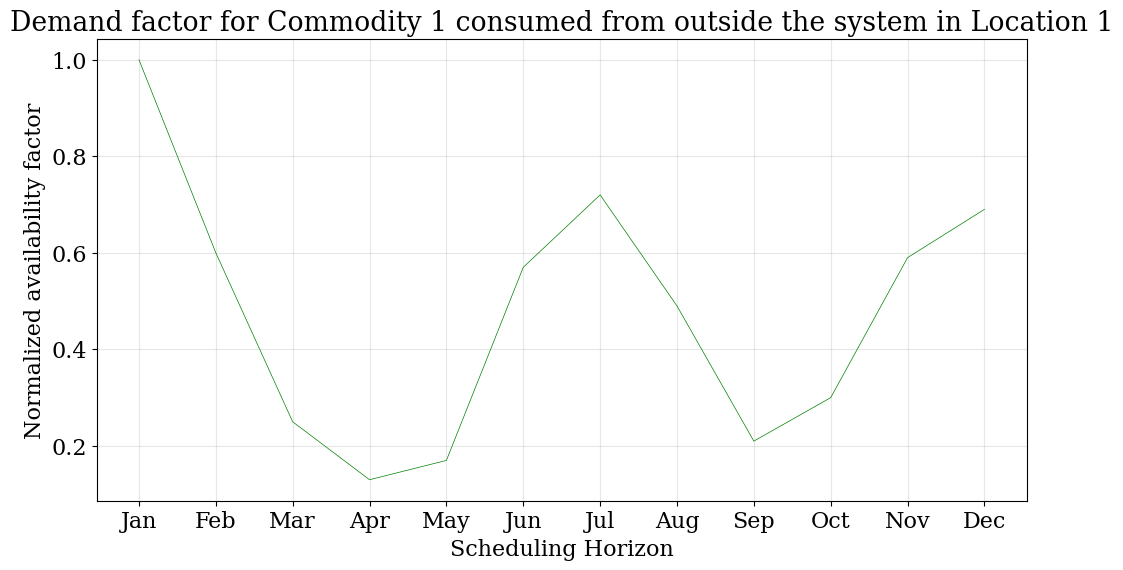

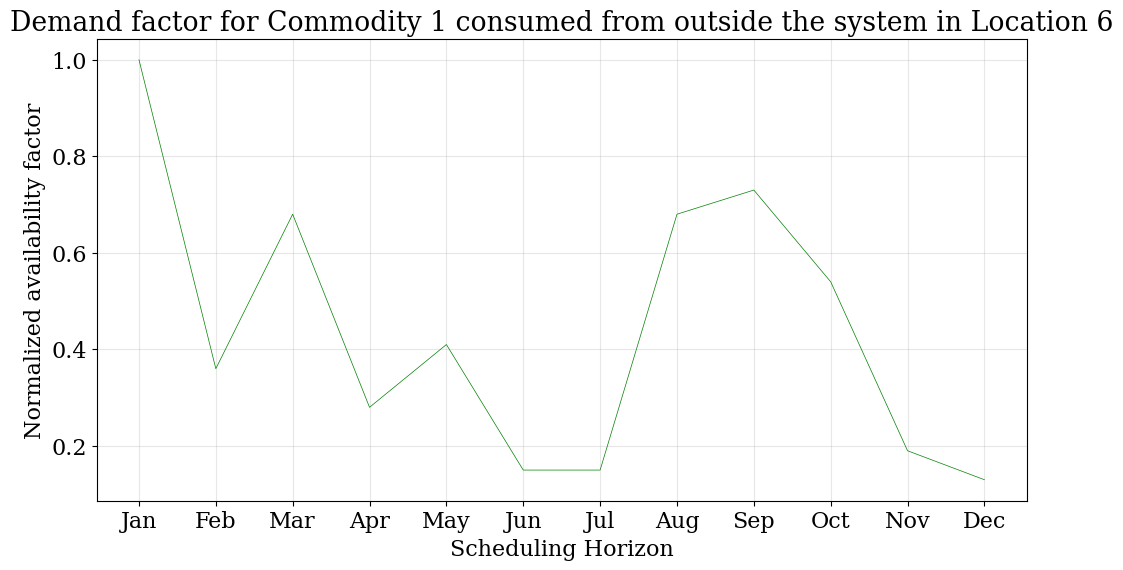

In [212]:
plot_scenario.availability_factor(scenario=scenario_disruption76, resource=com1_pur, location=loc1, color='green')
plot_scenario.availability_factor(scenario=scenario_disruption76, resource=com1_pur, location=loc6, color='green')

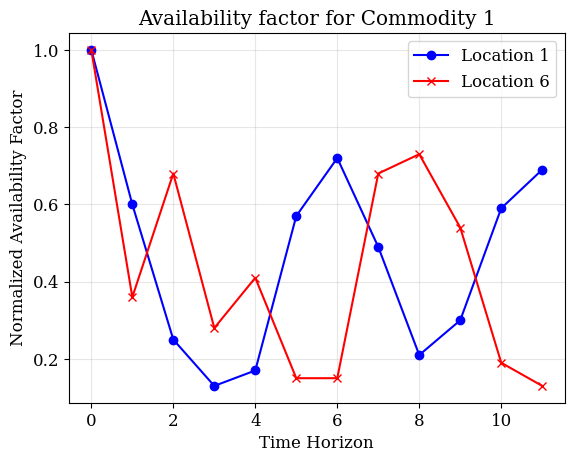

In [213]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(scenario_disruption76.availability_factor['loc1']['com1_pur'])), list(scenario_disruption76.availability_factor['loc1']['com1_pur'].values()), label='Location 1', color='blue', marker='o')

# Plot data from the second dataset
ax.plot(range(len(scenario_disruption76.availability_factor['loc6']['com1_pur'])), list(scenario_disruption76.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Normalized Availability Factor')
ax.set_title('Availability factor for Commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [214]:
problem_mincost = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty


In [215]:
problem_mincost76 = formulate(scenario=scenario_disruption76, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

min_demand76 = min_demand_dict76
if isinstance(min_demand76, dict):
    if isinstance(list(min_demand76.keys())[0], Location):
        try:
            min_demand = {i.name: {
                j.name: min_demand76[i][j] for j in min_demand76[i].keys()} for i in min_demand76.keys()}
        except:
            pass

problem_mincost76.del_component(constraint_demand2)
problem_mincost76.constraint_demand2 = constraint_demand2(instance=problem_mincost76, demand=min_demand, demand_factor=scenario_disruption76.demand_factor, demand_scale_level=scenario_disruption76.demand_scale_level, scheduling_scale_level=scenario_disruption76.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty
constraint demand2


In [216]:
problem_mincost80 = formulate(scenario=scenario_disruption80, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

min_demand80 = min_demand_dict80
if isinstance(min_demand80, dict):
    if isinstance(list(min_demand80.keys())[0], Location):
        try:
            min_demand = {i.name: {
                j.name: min_demand80[i][j] for j in min_demand80[i].keys()} for i in min_demand80.keys()}
        except:
            pass

problem_mincost80.del_component(constraint_demand2)
problem_mincost80.constraint_demand2 = constraint_demand2(instance=problem_mincost80, demand=min_demand, demand_factor=scenario_disruption80.demand_factor, demand_scale_level=scenario_disruption80.demand_scale_level, scheduling_scale_level=scenario_disruption80.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty
constraint demand2


In [217]:
problem_mincost82 = formulate(scenario=scenario_disruption82, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

min_demand82 = min_demand_dict82
if isinstance(min_demand82, dict):
    if isinstance(list(min_demand82.keys())[0], Location):
        try:
            min_demand = {i.name: {
                j.name: min_demand82[i][j] for j in min_demand82[i].keys()} for i in min_demand82.keys()}
        except:
            pass

problem_mincost82.del_component(constraint_demand2)
problem_mincost82.constraint_demand2 = constraint_demand2(instance=problem_mincost82, demand=min_demand, demand_factor=scenario_disruption82.demand_factor, demand_scale_level=scenario_disruption82.demand_scale_level, scheduling_scale_level=scenario_disruption82.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty
constraint demand2


In [218]:
results_mincost = solve(scenario=scenario_disruption, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 346781 rows, 851707 columns and 748709 nonzeros
Model fingerprint: 0x87bdea84
Variable types: 851462 continuous, 245 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+06]
Found heuristic solution: objective 1.800000e+08
Presolve removed 331458 rows and 838368 columns
Presolve time: 0.68s
Presolved: 15323 rows, 13339 columns, 47206 nonzeros
Variable types: 13339 continuous, 0 integer (0 binary)

Root relaxation: objective 8.364745e+07, 24179 iterations, 2.54 seconds (3.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

In [219]:
results_mincost76 = solve(scenario=scenario_disruption76, instance=problem_mincost76, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 349301 rows, 851707 columns and 751229 nonzeros
Model fingerprint: 0xa4f4c3be
Variable types: 851462 continuous, 245 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+06]
Presolve removed 333978 rows and 838008 columns
Presolve time: 0.64s
Presolved: 15323 rows, 13699 columns, 47566 nonzeros
Variable types: 13699 continuous, 0 integer (0 binary)

Root relaxation: objective 8.364745e+07, 22097 iterations, 2.38 seconds (2.91 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0  

In [220]:
results_mincost80 = solve(scenario=scenario_disruption80, instance=problem_mincost80, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 349301 rows, 851707 columns and 751229 nonzeros
Model fingerprint: 0x5ea14532
Variable types: 851462 continuous, 245 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+06]
Presolve removed 333978 rows and 838008 columns
Presolve time: 0.65s
Presolved: 15323 rows, 13699 columns, 47566 nonzeros
Variable types: 13699 continuous, 0 integer (0 binary)

Root relaxation: objective 8.364745e+07, 21552 iterations, 2.15 seconds (2.15 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0  

In [221]:
results_mincost82 = solve(scenario=scenario_disruption82, instance=problem_mincost82, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 349301 rows, 851707 columns and 751229 nonzeros
Model fingerprint: 0xbe0b1ba0
Variable types: 851462 continuous, 245 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+06]
Presolve removed 333978 rows and 838008 columns
Presolve time: 0.67s
Presolved: 15323 rows, 13699 columns, 47566 nonzeros
Variable types: 13699 continuous, 0 integer (0 binary)

Root relaxation: objective 8.370803e+07, 20857 iterations, 2.19 seconds (2.35 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0  

In [241]:
sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold' and value!=0)/(100*_exec_scenarios*_time_intervals)
min(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

0.0

In [242]:
sum(value for key, value in results_mincost76.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/(100*_exec_scenarios*_time_intervals)
min(value for key, value in results_mincost76.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

76.0

In [243]:
sum(value for key, value in results_mincost80.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/(100*_exec_scenarios*_time_intervals)
min(value for key, value in results_mincost80.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

80.0

In [244]:
sum(value for key, value in results_mincost82.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/(100*_exec_scenarios*_time_intervals)
min(value for key, value in results_mincost82.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

82.0

In [240]:
print([(key, value) for key, value in results_mincost.output['S'].items()])

{('loc1', 'com1_sold', 0, 0, 0): 0.0,
 ('loc1', 'com1_sold', 0, 0, 1): 0.0,
 ('loc1', 'com1_sold', 0, 0, 2): 0.0,
 ('loc1', 'com1_sold', 0, 0, 3): 0.0,
 ('loc1', 'com1_sold', 0, 0, 4): 0.0,
 ('loc1', 'com1_sold', 0, 0, 5): 0.0,
 ('loc1', 'com1_sold', 0, 0, 6): 0.0,
 ('loc1', 'com1_sold', 0, 0, 7): 0.0,
 ('loc1', 'com1_sold', 0, 0, 8): 0.0,
 ('loc1', 'com1_sold', 0, 0, 9): 0.0,
 ('loc1', 'com1_sold', 0, 0, 10): 0.0,
 ('loc1', 'com1_sold', 0, 0, 11): 0.0,
 ('loc1', 'com1_sold', 0, 0, 12): 0.0,
 ('loc1', 'com1_sold', 0, 0, 13): 0.0,
 ('loc1', 'com1_sold', 0, 0, 14): 0.0,
 ('loc1', 'com1_sold', 0, 0, 15): 0.0,
 ('loc1', 'com1_sold', 0, 0, 16): 0.0,
 ('loc1', 'com1_sold', 0, 0, 17): 0.0,
 ('loc1', 'com1_sold', 0, 0, 18): 0.0,
 ('loc1', 'com1_sold', 0, 0, 19): 0.0,
 ('loc1', 'com1_sold', 0, 0, 20): 0.0,
 ('loc1', 'com1_sold', 0, 0, 21): 0.0,
 ('loc1', 'com1_sold', 0, 0, 22): 0.0,
 ('loc1', 'com1_sold', 0, 0, 23): 0.0,
 ('loc1', 'com1_sold', 0, 0, 24): 0.0,
 ('loc1', 'com1_sold', 0, 0, 25): 0

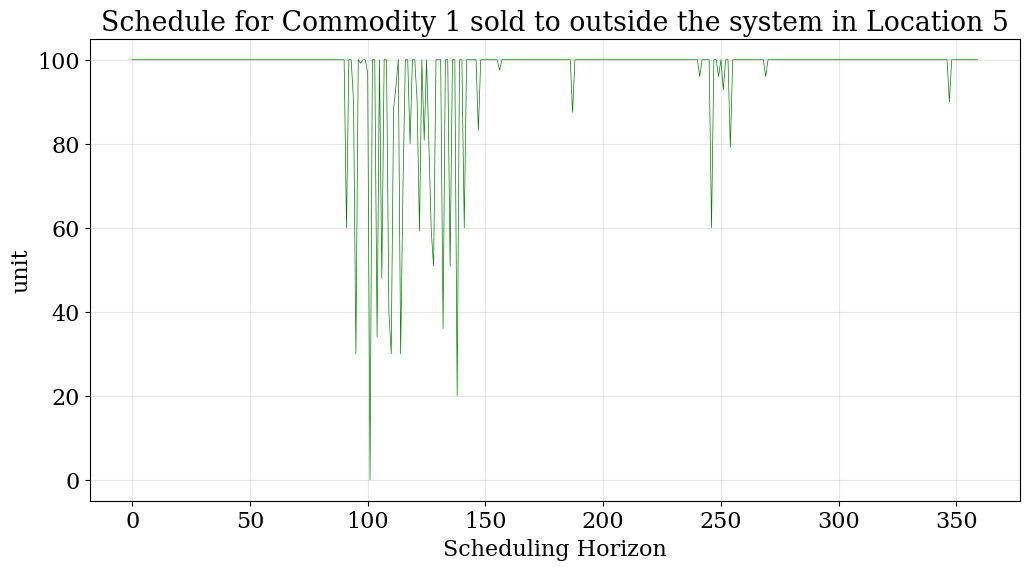

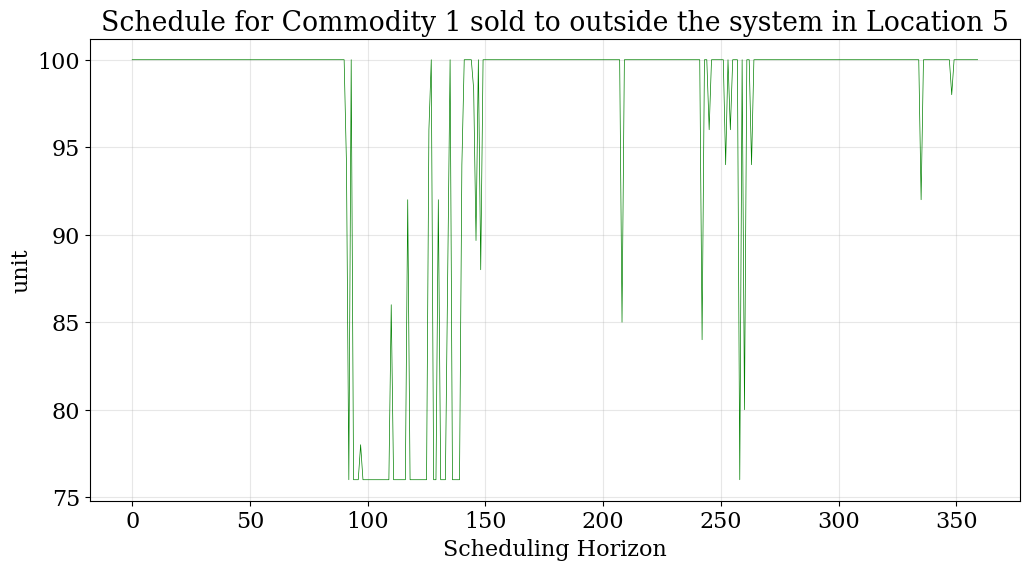

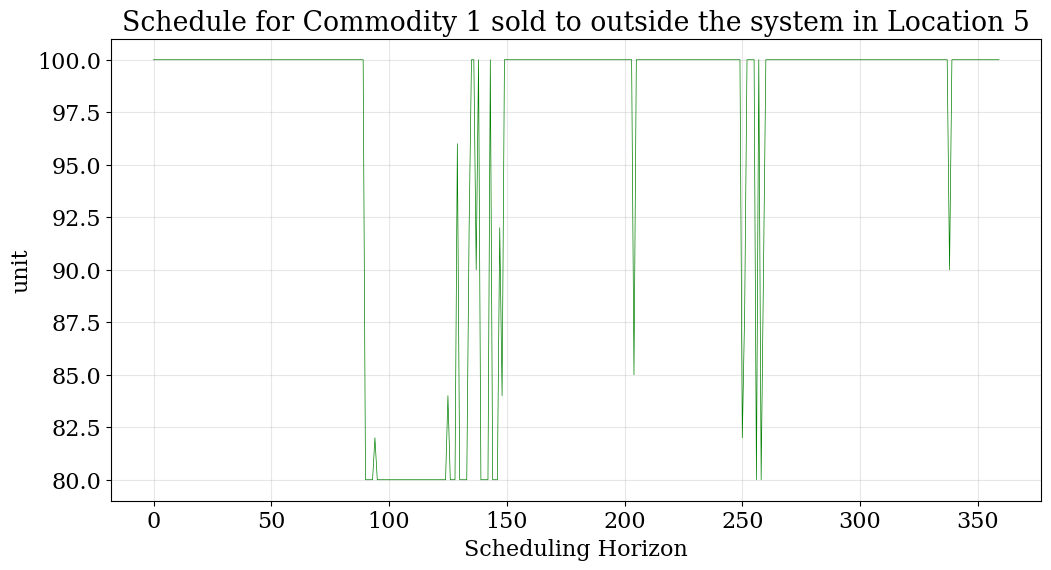

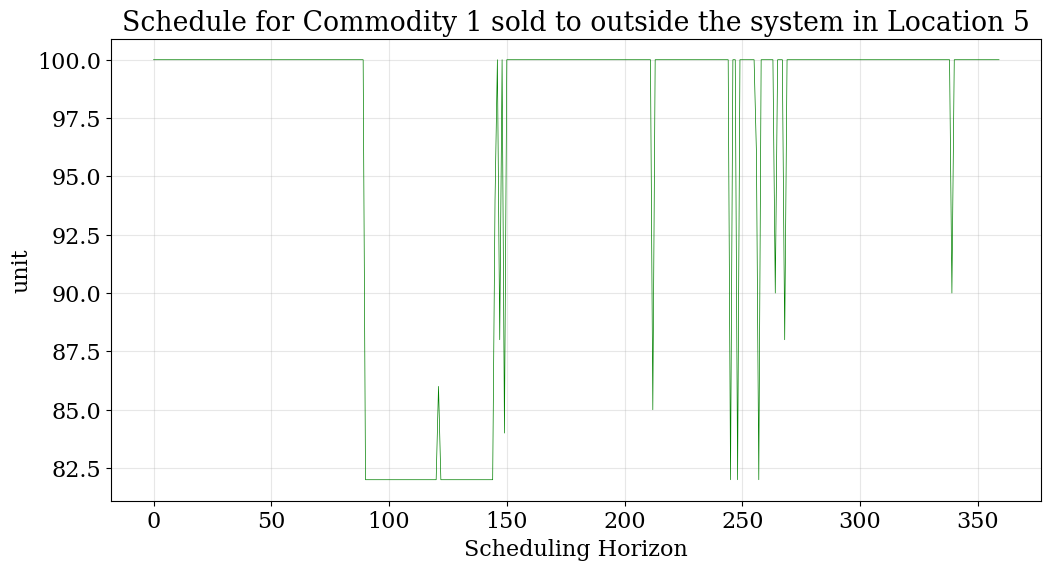

In [226]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')
plot_results.schedule(results=results_mincost76, y_axis='S', component='com1_sold', location='loc5', color='green')
plot_results.schedule(results=results_mincost80, y_axis='S', component='com1_sold', location='loc5', color='green')
plot_results.schedule(results=results_mincost82, y_axis='S', component='com1_sold', location='loc5', color='green')

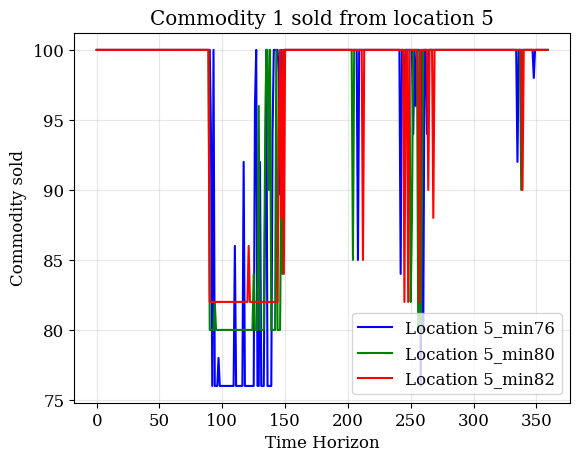

In [245]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
# ax.plot(range(len(list(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'))), list(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'), label='Location 5', color='yellow')

ax.plot(range(len(list(value for key, value in results_mincost76.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'))), list(value for key, value in results_mincost76.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'), label='Location 5_min76', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost80.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'))), list(value for key, value in results_mincost80.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'), label='Location 5_min80', color='green')

ax.plot(range(len(list(value for key, value in results_mincost82.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'))), list(value for key, value in results_mincost82.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'), label='Location 5_min82', color='red')

# Plot data from the second dataset
# ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Commodity sold')
ax.set_title('Commodity 1 sold from location 5')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

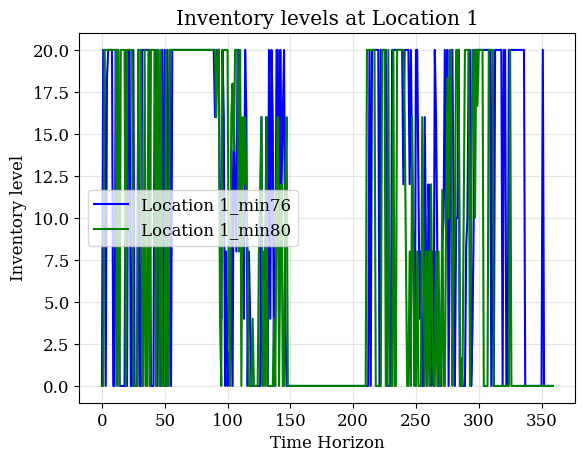

In [277]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
# ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='Location 1', color='yellow')

ax.plot(range(len(list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='Location 1_min76', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='Location 1_min80', color='green')

# ax.plot(range(len(list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='Location 1_min82', color='red')

# Plot data from the second dataset
# ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels at Location 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

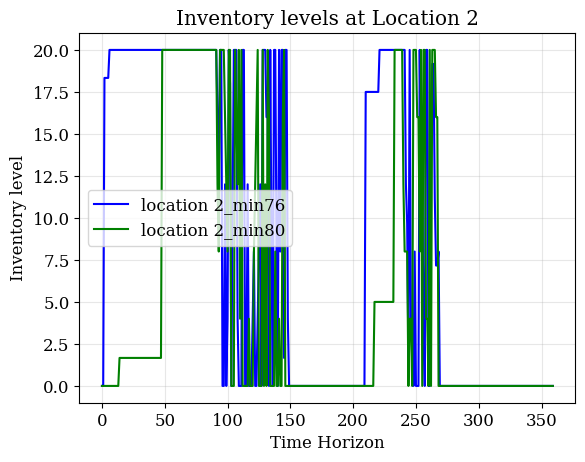

In [278]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
# ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='location 2', color='yellow')

ax.plot(range(len(list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='location 2_min76', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='location 2_min80', color='green')

# ax.plot(range(len(list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='location 2_min82', color='red')

# Plot data from the second dataset
# ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels at Location 2')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

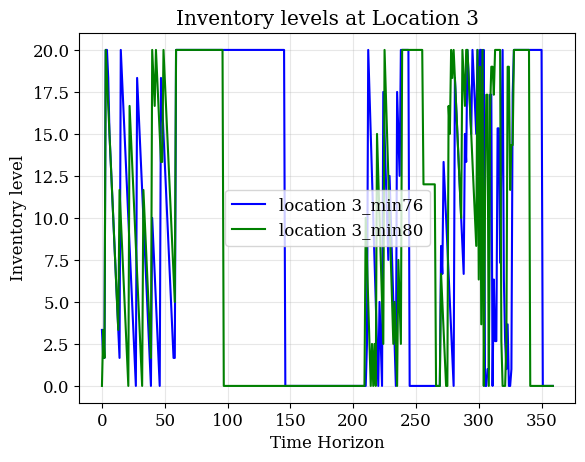

In [279]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
# ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'), label='location 3', color='yellow')

ax.plot(range(len(list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'), label='location 3_min76', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'), label='location 3_min80', color='green')

# ax.plot(range(len(list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'), label='location 3_min82', color='red')

# Plot data from the second dataset
# ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels at Location 3')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

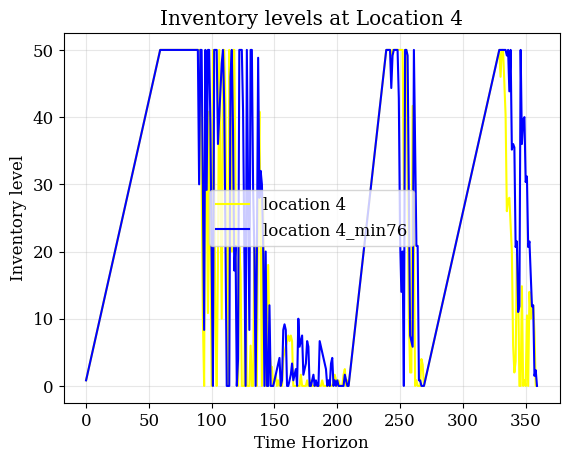

In [254]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'), label='location 4', color='yellow')

ax.plot(range(len(list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'), label='location 4_min76', color='blue')

# ax.plot(range(len(list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'), label='location 4_min80', color='green')

# ax.plot(range(len(list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'), label='location 4_min82', color='red')

# Plot data from the second dataset
# ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels at Location 4')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

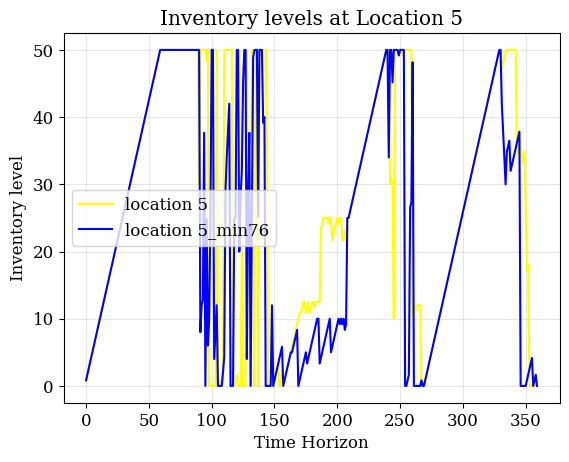

In [255]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'), label='location 5', color='yellow')

ax.plot(range(len(list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'), label='location 5_min76', color='blue')

# ax.plot(range(len(list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'), label='location 5_min80', color='green')

# ax.plot(range(len(list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'), label='location 5_min82', color='red')

# Plot data from the second dataset
# ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels at Location 5')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

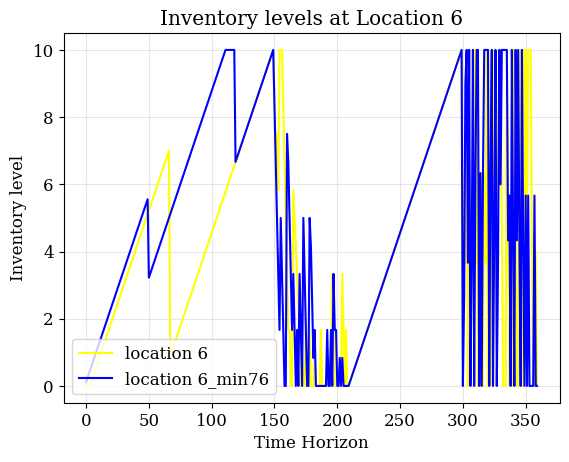

In [256]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='location 6', color='yellow')

ax.plot(range(len(list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='location 6_min76', color='blue')

# ax.plot(range(len(list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='location 6_min80', color='green')
# 
# ax.plot(range(len(list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='location 6_min82', color='red')

# Plot data from the second dataset
# ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels at Location 6')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

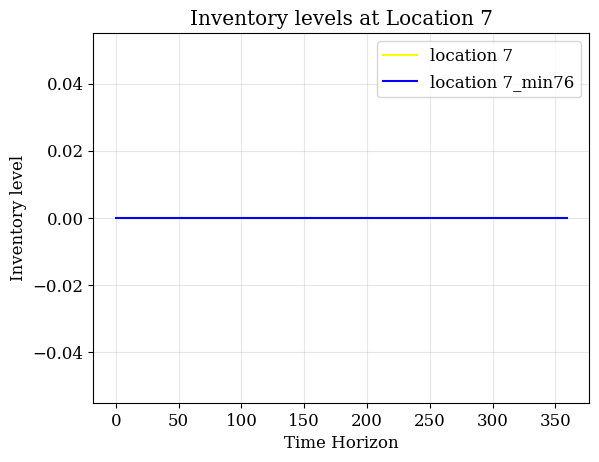

In [257]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='location 7', color='yellow')

ax.plot(range(len(list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost76.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='location 7_min76', color='blue')

# ax.plot(range(len(list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost80.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='location 7_min80', color='green')
# 
# ax.plot(range(len(list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost82.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='location 7_min82', color='red')

# Plot data from the second dataset
# ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels at Location 7')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [258]:
sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold' and value!=0)/(100*_exec_scenarios*_time_intervals)

0.9681944444444445

In [235]:
sum(value for key, value in results_mincost76.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold' and value!=0)/(100*_exec_scenarios*_time_intervals)

0.9681944444444445

In [236]:
sum(value for key, value in results_mincost80.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold' and value!=0)/(100*_exec_scenarios*_time_intervals)

0.9681944444444445

In [237]:
sum(value for key, value in results_mincost82.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold' and value!=0)/(100*_exec_scenarios*_time_intervals)


0.96875

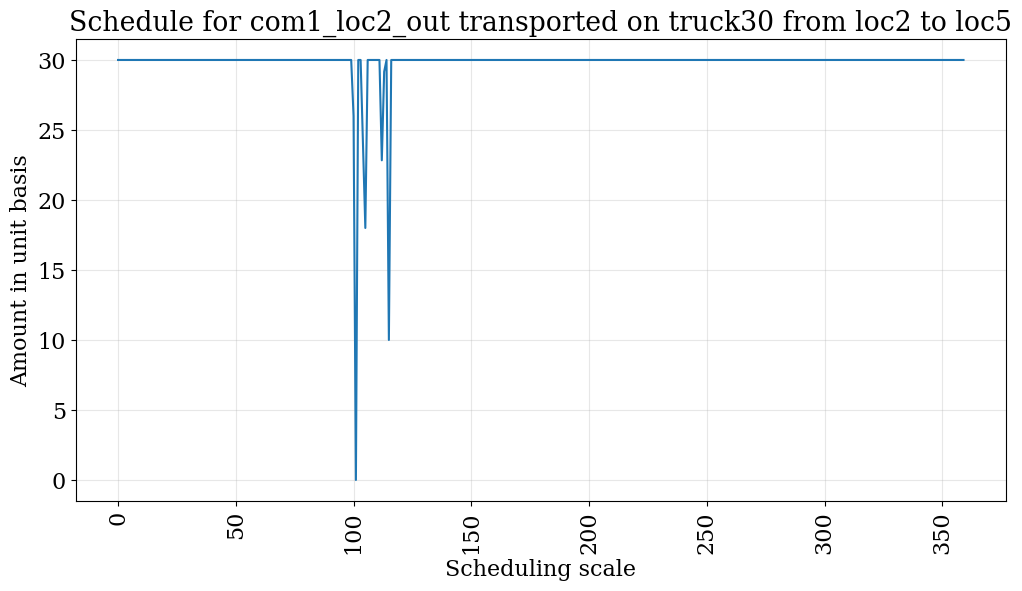

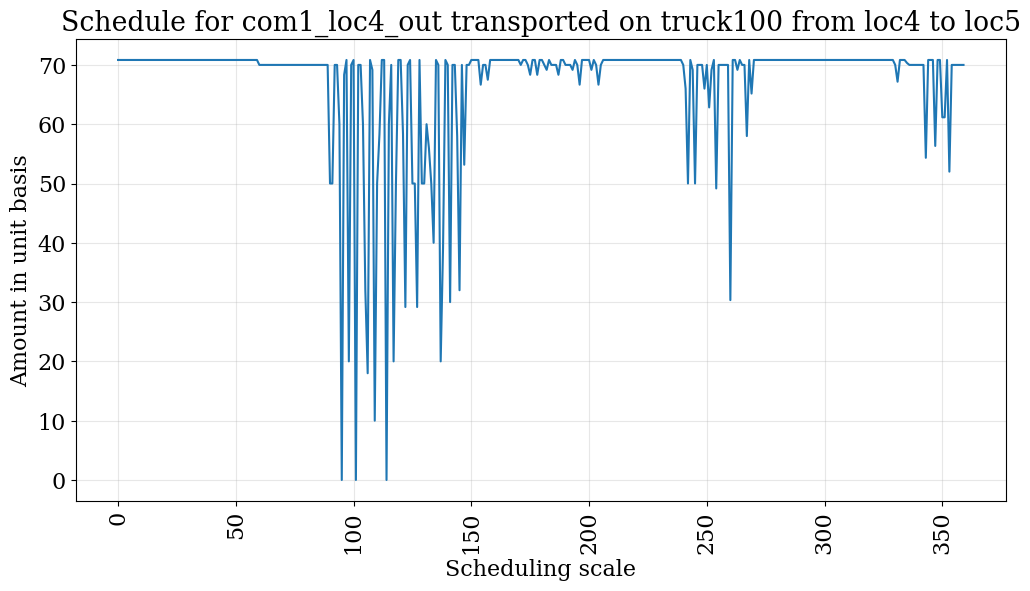

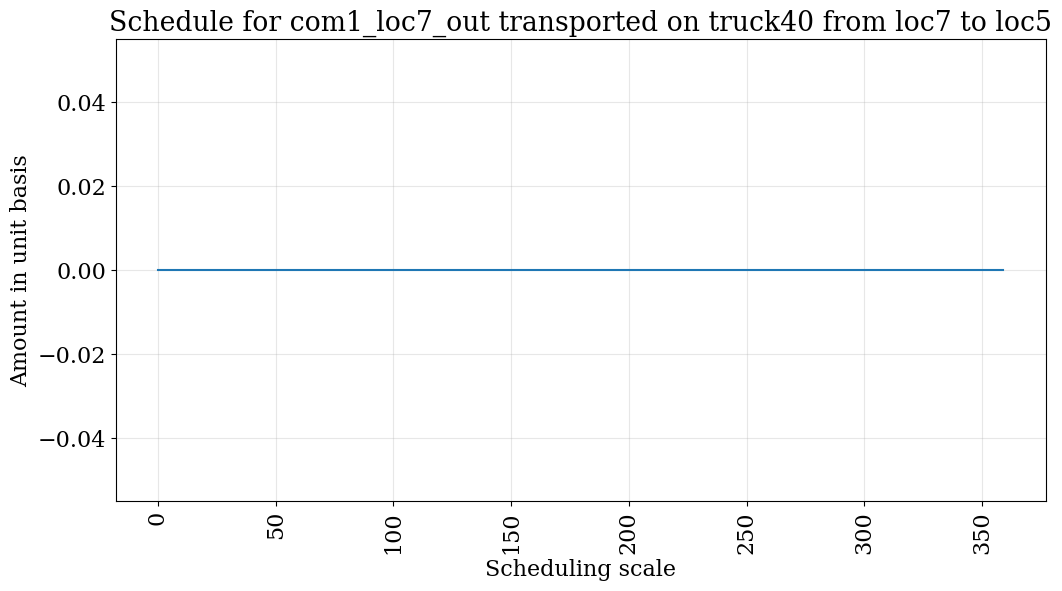

In [238]:
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30', resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100', resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40', resource='com1_loc7_out')

In [262]:
results_mincost.output['objective']

83647452.77777778

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

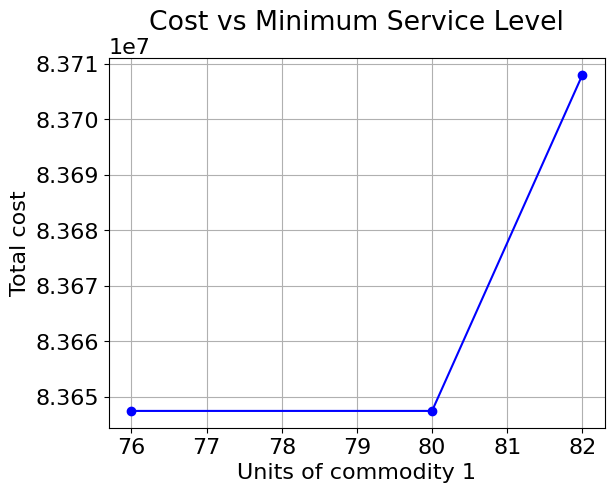

In [275]:
import matplotlib.pyplot as plt

x = [ min(value for key, value in results_mincost76.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'),
     min(value for key, value in results_mincost80.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'),
     min(value for key, value in results_mincost82.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')]
y = [results_mincost76.output['objective'], results_mincost80.output['objective'], results_mincost82.output['objective']]

plt.plot(x, y, label='Data Points', color='blue', marker='o')

plt.xlabel('Units of commodity 1')
plt.ylabel('Total cost')
plt.title('Cost vs Minimum Service Level')
plt.grid(True)

plt.show()

In [271]:
min_demand_satisfactionmax = 0.85
min_demand_dictmax = {i: {com1_sold: min_demand_satisfactionmax * 100} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_disruptionmax = Scenario(name='scenario_disruptionmax', scales=scales, scheduling_scale_level=2,
                               network_scale_level=0, purchase_scale_level=2, availability_scale_level=1,
                               demand_scale_level=2, capacity_scale_level=1,
                               network=network, demand=demand_dict, demand_penalty=demand_penalty_dict,
                               label='scenario_disruptionmax')

In [272]:
problem_mincostmax = formulate(scenario=scenario_disruptionmax, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

min_demandmax = min_demand_dictmax
if isinstance(min_demandmax, dict):
    if isinstance(list(min_demandmax.keys())[0], Location):
        try:
            min_demand = {i.name: {
                j.name: min_demandmax[i][j] for j in min_demandmax[i].keys()} for i in min_demandmax.keys()}
        except:
            pass

problem_mincostmax.del_component(constraint_demand2)
problem_mincostmax.constraint_demand2 = constraint_demand2(instance=problem_mincostmax, demand=min_demand, demand_factor=scenario_disruptionmax.demand_factor, demand_scale_level=scenario_disruptionmax.demand_scale_level, scheduling_scale_level=scenario_disruptionmax.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty
constraint demand2


In [273]:
results_mincostmax = solve(scenario=scenario_disruptionmax, instance=problem_mincostmax, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 349301 rows, 851707 columns and 751229 nonzeros
Model fingerprint: 0x41cba3da
Variable types: 851462 continuous, 245 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+06]
Presolve removed 333978 rows and 838008 columns
Presolve time: 0.64s
Presolved: 15323 rows, 13699 columns, 47566 nonzeros
Variable types: 13699 continuous, 0 integer (0 binary)

Root relaxation: infeasible, 14251 iterations, 1.42 seconds (1.20 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasi

KeyError: 'S'

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

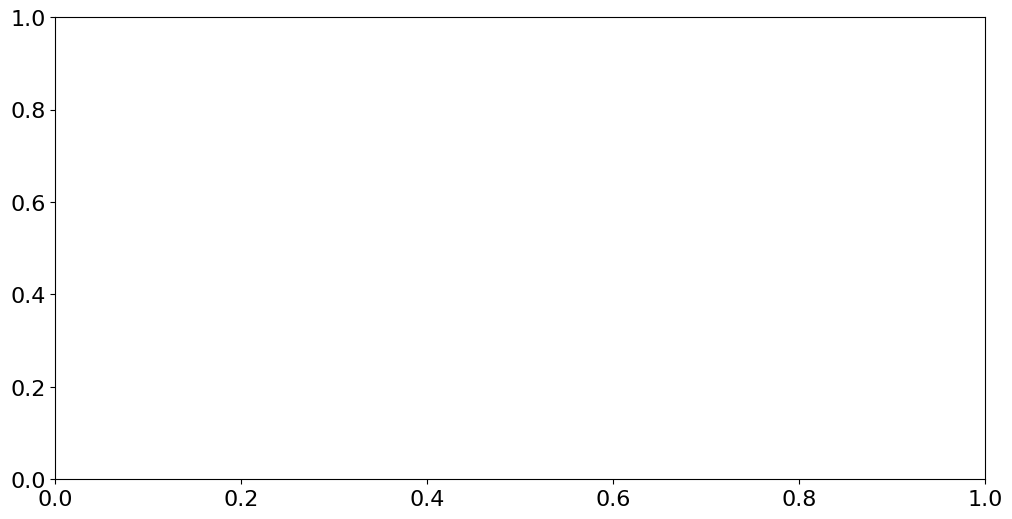

In [274]:
plot_results.schedule(results=results_mincostmax, y_axis='S', component='com1_sold', location='loc5', color='green')